In [62]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, QuantileTransformer
from sklearn.model_selection import train_test_split, GridSearchCV

import graphviz
from six import StringIO 
import pydotplus

from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, plot_confusion_matrix, plot_roc_curve, \
                                fbeta_score, make_scorer

In [3]:
df = pd.read_csv('CLEAN_MHCLD.csv')

In [4]:
X = df.drop('Diagnosed Depression', axis=1)
y = df['Diagnosed Depression'].map({0.0: 0, 1.0: 1})

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=.20, random_state=42, shuffle=True)

# View sizes of data
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(22367, 30)
(22367,)
(5592, 30)
(5592,)


In [5]:
# Check value counts for the targets
y_train.value_counts(1)

0    0.577368
1    0.422632
Name: Diagnosed Depression, dtype: float64

# Model Preparation

In [6]:
encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)

# Choose the columns to be one hot encoded
ohe_cols = x_train.select_dtypes('O').columns
ohe_cols

Index(['Ethnicity', 'RACE', 'Marital Status', 'Employment Status',
       'Not in Labor Force', 'Residential Status', 'MH1', 'SMISED'],
      dtype='object')

In [7]:
# One hot encode the categorical features of the training set and test set

ohe_train = encoder.fit_transform(x_train[ohe_cols])
ohe_test = encoder.transform(x_test[ohe_cols])

In [8]:
# Visualize the one hot encoded features

ohe_train_df = pd.DataFrame(ohe_train, columns=encoder.get_feature_names_out(ohe_cols), index=x_train.index)
ohe_test_df = pd.DataFrame(ohe_test, columns=encoder.get_feature_names_out(ohe_cols), index=x_test.index)

ohe_train_df.head()

Ethnicity_Mexican  Ethnicity_Not Hispanic  Ethnicity_Other Hispanic  \
20949                0.0                     1.0                       0.0   
18497                0.0                     1.0                       0.0   
21331                0.0                     1.0                       0.0   
24136                0.0                     1.0                       0.0   
2704                 0.0                     1.0                       0.0   

       Ethnicity_Puerto Rican  RACE_American Indian  RACE_Asian  \
20949                     0.0                   0.0         0.0   
18497                     0.0                   0.0         0.0   
21331                     0.0                   0.0         0.0   
24136                     0.0                   0.0         0.0   
2704                      0.0                   0.0         0.0   

       RACE_Black or African American  \
20949                             1.0   
18497                             0.0   
21331                             0.0   
24136                             0.0   
2704                              1.0   

       RACE_Native Hawaiian or Other Pacific Islander  RACE_Two or more races  \
20949                                             0.0                     0.0   
18497                                             0.0                     0.0   
21331                                             0.0                     0.0   
24136                                             0.0                     0.0   
2704                                              0.0                     0.0   

       RACE_White  ...  MH1_Missing  MH1_Oppositional Defiant Disorders  \
20949         0.0  ...          0.0                                 0.0   
18497         1.0  ...          0.0                                 0.0   
21331         1.0  ...          0.0                                 0.0   
24136         1.0  ...          1.0                                 0.0   
2704          0.0  ...          0.0                                 0.0   

       MH1_Other disorders  MH1_Personality disorders  \
20949                  0.0                        0.0   
18497                  0.0                        0.0   
21331                  0.0                        0.0   
24136                  0.0                        0.0   
2704                   0.0                        0.0   

       MH1_Pervasive Developmental Disorders  \
20949                                    0.0   
18497                                    0.0   
21331                                    0.0   
24136                                    0.0   
2704                                     0.0   

       MH1_Schizophrenia or other psychosis  MH1_Trauma Disorder  \
20949                                   0.0                  0.0   
18497                                   0.0                  1.0   
21331                                   0.0                  0.0   
24136                                   0.0                  0.0   
2704                                    0.0                  1.0   

       SMISED_Not serious  SMISED_Serious Emotional Disorder  \
20949                 0.0                                1.0   
18497                 0.0                                1.0   
21331                 0.0                                1.0   
24136                 0.0                                0.0   
2704                  0.0                                1.0   

       SMISED_Serious Mental Illness  
20949                            0.0  
18497                            0.0  
21331                            0.0  
24136                            1.0  
2704                             0.0  

[5 rows x 39 columns]

In [9]:
# Explore the numerical columns -> scaling to get features in similar range?

numerical_cols = x_train.select_dtypes('number').columns
numerical_cols

Index(['Unnamed: 0', 'AGE', 'Education', 'GENDER', 'VETERAN', 'SAP',
       'Anxiety disorder', 'ADHDFLG', 'BIPOLARFLG', 'Schizophrenia',
       'Trauma Disorders', 'Conduct Disorders', 'Delirium/Dementia',
       'Oppositional Defiant Disorder', 'Pervasive Development Disorder',
       'Personality Disorder', 'Alcohol/Substance Use Disorder',
       'State psychiatric hospital', 'Community Mental Health Center',
       'Other psychiatric inpatient', 'Residential Treatment Center',
       'justice system services'],
      dtype='object')

In [10]:
numerical_cols = numerical_cols[1:]

In [11]:
transformer = QuantileTransformer(output_distribution='uniform', random_state=42)

train_transform = transformer.fit_transform(x_train[numerical_cols])
test_transform = transformer.transform(x_test[numerical_cols])

In [12]:
# Visualize the scaled features

train_transform_df = pd.DataFrame(train_transform, columns=x_train[numerical_cols].columns, index=x_train.index)
test_transform_df = pd.DataFrame(test_transform, columns=x_test[numerical_cols].columns, index=x_test.index)

train_transform_df.head()

AGE  Education  GENDER  VETERAN  SAP  Anxiety disorder  ADHDFLG  \
20949  0.341842   0.286286     1.0      0.0  0.0               1.0      0.0   
18497  0.773774   0.081081     1.0      1.0  0.0               0.0      0.0   
21331  0.134635   0.286286     0.0      0.0  0.0               1.0      0.0   
24136  0.000000   0.081081     1.0      0.0  0.0               0.0      0.0   
2704   0.134635   0.000000     1.0      0.0  0.0               0.0      0.0   

       BIPOLARFLG  Schizophrenia  Trauma Disorders  ...  Delirium/Dementia  \
20949         0.0            0.0               0.0  ...                0.0   
18497         0.0            0.0               0.0  ...                0.0   
21331         0.0            0.0               1.0  ...                0.0   
24136         0.0            1.0               0.0  ...                0.0   
2704          0.0            0.0               0.0  ...                0.0   

       Oppositional Defiant Disorder  Pervasive Development Disorder  \
20949                            0.0                             0.0   
18497                            0.0                             0.0   
21331                            0.0                             0.0   
24136                            0.0                             0.0   
2704                             0.0                             0.0   

       Personality Disorder  Alcohol/Substance Use Disorder  \
20949                   0.0                             0.0   
18497                   0.0                             0.0   
21331                   0.0                             0.0   
24136                   0.0                             0.0   
2704                    0.0                             0.0   

       State psychiatric hospital  Community Mental Health Center  \
20949                         0.0                             1.0   
18497                         0.0                             1.0   
21331                         0.0                             1.0   
24136                         0.0                             1.0   
2704                          0.0                             1.0   

       Other psychiatric inpatient  Residential Treatment Center  \
20949                          0.0                           0.0   
18497                          0.0                           0.0   
21331                          0.0                           0.0   
24136                          0.0                           0.0   
2704                           0.0                           0.0   

       justice system services  
20949                      0.0  
18497                      0.0  
21331                      0.0  
24136                      0.0  
2704                       0.0  

[5 rows x 21 columns]

In [13]:
# Scaled data
x_train_scaled = pd.concat([ohe_train_df, train_transform_df], axis=1)
x_test_scaled = pd.concat([ohe_test_df, test_transform_df], axis=1)

x_train_scaled.head()

Ethnicity_Mexican  Ethnicity_Not Hispanic  Ethnicity_Other Hispanic  \
20949                0.0                     1.0                       0.0   
18497                0.0                     1.0                       0.0   
21331                0.0                     1.0                       0.0   
24136                0.0                     1.0                       0.0   
2704                 0.0                     1.0                       0.0   

       Ethnicity_Puerto Rican  RACE_American Indian  RACE_Asian  \
20949                     0.0                   0.0         0.0   
18497                     0.0                   0.0         0.0   
21331                     0.0                   0.0         0.0   
24136                     0.0                   0.0         0.0   
2704                      0.0                   0.0         0.0   

       RACE_Black or African American  \
20949                             1.0   
18497                             0.0   
21331                             0.0   
24136                             0.0   
2704                              1.0   

       RACE_Native Hawaiian or Other Pacific Islander  RACE_Two or more races  \
20949                                             0.0                     0.0   
18497                                             0.0                     0.0   
21331                                             0.0                     0.0   
24136                                             0.0                     0.0   
2704                                              0.0                     0.0   

       RACE_White  ...  Delirium/Dementia  Oppositional Defiant Disorder  \
20949         0.0  ...                0.0                            0.0   
18497         1.0  ...                0.0                            0.0   
21331         1.0  ...                0.0                            0.0   
24136         1.0  ...                0.0                            0.0   
2704          0.0  ...                0.0                            0.0   

       Pervasive Development Disorder  Personality Disorder  \
20949                             0.0                   0.0   
18497                             0.0                   0.0   
21331                             0.0                   0.0   
24136                             0.0                   0.0   
2704                              0.0                   0.0   

       Alcohol/Substance Use Disorder  State psychiatric hospital  \
20949                             0.0                         0.0   
18497                             0.0                         0.0   
21331                             0.0                         0.0   
24136                             0.0                         0.0   
2704                              0.0                         0.0   

       Community Mental Health Center  Other psychiatric inpatient  \
20949                             1.0                          0.0   
18497                             1.0                          0.0   
21331                             1.0                          0.0   
24136                             1.0                          0.0   
2704                              1.0                          0.0   

       Residential Treatment Center  justice system services  
20949                           0.0                      0.0  
18497                           0.0                      0.0  
21331                           0.0                      0.0  
24136                           0.0                      0.0  
2704                            0.0                      0.0  

[5 rows x 60 columns]

In [29]:
# Removing a column dedicated to missing values
x_train_scaled.drop(columns=['MH1_Missing'], inplace=True)

In [33]:
x_test_scaled.drop(columns=['MH1_Missing'], inplace=True)

# Modeling
- It is important to note that measuring model performance using regular accuracy is not desirable for predicting whether or not
someone has depression. In the context of a confusion matrix, we would like to have more classifications that result
in false positives than false negatives. Due to the fact that classifying those who have depression even when they
do not is better than not identifying patients who in fact have depression - worst case senario is that the patient
with depression harms themself. 
- To account for this discrepancy, we use a weighted F1-score where the measure of recall is weighed more heavily
to reduce possible false negatives

In [15]:
# Primary metric to evaluate model performance - weigh recall more heavily
f2_scorer = make_scorer(score_func=fbeta_score, beta=2)

## Decision Tree Base and Grid Searched 
- Goal: gain insight into the relevant features of our dataset

In [30]:
decision_tree = DecisionTreeClassifier(random_state=42)

# Training the decision_tree on all available features
decision_tree.fit(x_train_scaled, y_train)

DecisionTreeClassifier(random_state=42)

In [31]:
# Plotting the tree
dot_data = export_graphviz(decision_tree, out_file=None) 
graph = graphviz.Source(dot_data) 
dot_data = export_graphviz(decision_tree, out_file=None, 
                            feature_names=x_train_scaled.columns.tolist(),   
                            class_names=['No Depression', 'Depression'],  
                            filled=True, rounded=True,   
                            special_characters=True)  
graph = graphviz.Source(dot_data)
graph 

- Model evaluation for Decision Tree Base

               precision    recall  f1-score   support

No Depression       0.97      0.96      0.97      3258
   Depression       0.95      0.96      0.95      2334

     accuracy                           0.96      5592
    macro avg       0.96      0.96      0.96      5592
 weighted avg       0.96      0.96      0.96      5592



/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


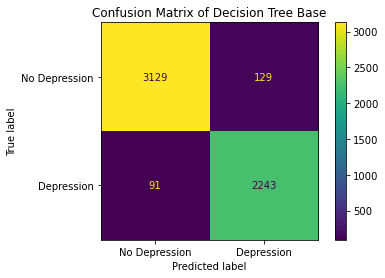

In [34]:
# Classification report
dt_preds = decision_tree.predict(x_test_scaled)
dt_report = classification_report(y_test, dt_preds,target_names=['No Depression', 'Depression'])
print(dt_report)

# Confusion matrix
fig_dt = plot_confusion_matrix(decision_tree, x_test_scaled, y_test, display_labels=['No Depression', 'Depression'])
plt.title('Confusion Matrix of Decision Tree Base')
plt.show()

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


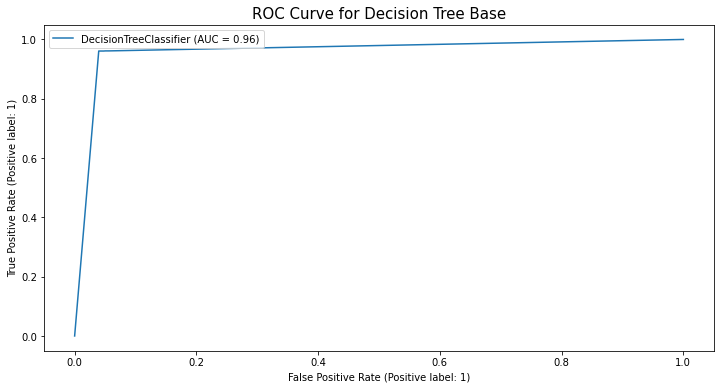

In [35]:
# ROC curve plot
f_dt, ax1 = plt.subplots(figsize=(12, 6), ncols=1)
roc_dt = plot_roc_curve(decision_tree, x_test_scaled, y_test, ax=ax1)
ax1.set_title('ROC Curve for Decision Tree Base', fontdict={'fontsize':15})
ax1.legend()
plt.show()

Text(0, 0.5, 'Importance level')

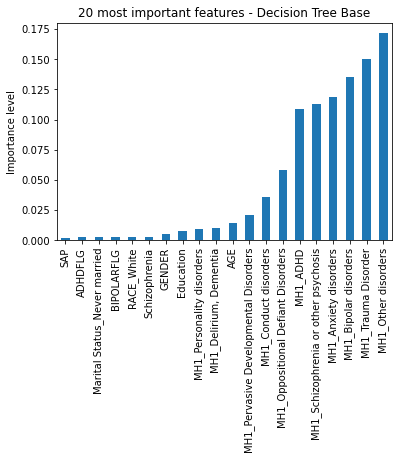

In [37]:
# Find the important features determined by the Decision Tree using gini to compute information gain

important_features = pd.Series(decision_tree.feature_importances_, index=x_train_scaled.columns)
important_features.nlargest(20).sort_values().plot(kind='bar')
plt.title('20 most important features - Decision Tree Base')
plt.ylabel('Importance level')

- Decision Tree Grid Search

In [38]:
dt_params = {'criterion': ['gini', 'entropy'], 
         'max_depth': [5, 20, 40, 50]}

decision_tree_grid = GridSearchCV(decision_tree, param_grid=dt_params, scoring=f2_scorer, cv=3)

# train the grid searched decision_tree
decision_tree_grid.fit(x_train_scaled, y_train)

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [5, 20, 40, 50]},
             scoring=make_scorer(fbeta_score, beta=2))

In [39]:
# Look at the optimal parameters for the decision tree
decision_tree_grid.best_params_

{'criterion': 'gini', 'max_depth': 20}

In [41]:
# Selecting the best classifier to make predictions on the test set
optimal_decision_tree = decision_tree_grid.best_estimator_

               precision    recall  f1-score   support

No Depression       0.97      0.96      0.97      3258
   Depression       0.95      0.96      0.95      2334

     accuracy                           0.96      5592
    macro avg       0.96      0.96      0.96      5592
 weighted avg       0.96      0.96      0.96      5592



/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


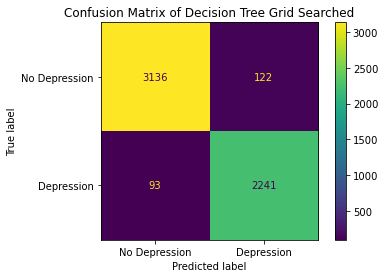

In [42]:
# Classification report
opt_dt_preds = optimal_decision_tree.predict(x_test_scaled)
opt_dt_report = classification_report(y_test, opt_dt_preds,target_names=['No Depression', 'Depression'])
print(opt_dt_report)

# Confusion matrix
fig_dt = plot_confusion_matrix(optimal_decision_tree, x_test_scaled, y_test, display_labels=['No Depression', 'Depression'])
plt.title('Confusion Matrix of Decision Tree Grid Searched')
plt.show()

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


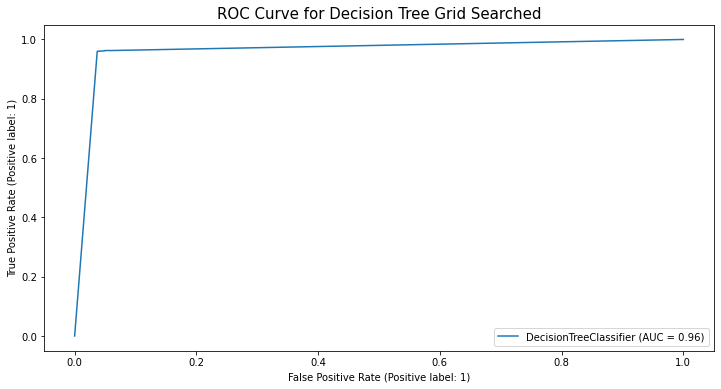

In [43]:
# ROC curve plot
f_opt_dt, ax2 = plt.subplots(figsize=(12, 6), ncols=1)
roc_opt_dt = plot_roc_curve(optimal_decision_tree, x_test_scaled, y_test, ax=ax2)
ax2.set_title('ROC Curve for Decision Tree Grid Searched', fontdict={'fontsize':15})
ax2.legend()
plt.show()

Text(0, 0.5, 'Importance level')

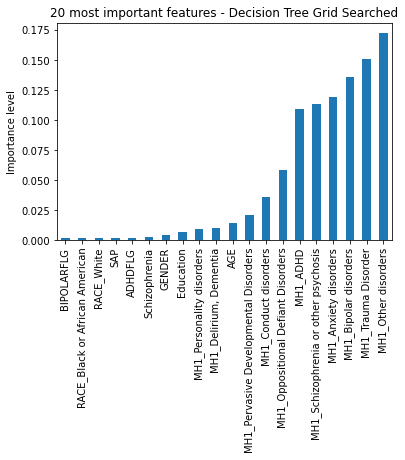

In [44]:
# Find the important features determined by the Grid Searched Decision Tree which used gini to compute information gain

important_features_grid = pd.Series(optimal_decision_tree.feature_importances_, index=x_train_scaled.columns)
important_features_grid.nlargest(20).sort_values().plot(kind='bar')
plt.title('20 most important features - Decision Tree Grid Searched')
plt.ylabel('Importance level')

## Logistic Regression Base and Grid Searched

In [46]:
# LogisticRegressionCV allows us to specify the number of cross validation folds
logreg = LogisticRegressionCV(cv=5, scoring=f2_scorer, n_jobs=-1)


# Train the Logistic Regression base model
logreg.fit(x_train_scaled, y_train)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegressionCV(cv=5, n_jobs=-1, scoring=make_scorer(fbeta_score, beta=2))

- Model Evaluation for Logistic Regression Base

               precision    recall  f1-score   support

No Depression       0.97      1.00      0.99      3258
   Depression       1.00      0.96      0.98      2334

     accuracy                           0.98      5592
    macro avg       0.99      0.98      0.98      5592
 weighted avg       0.98      0.98      0.98      5592



/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


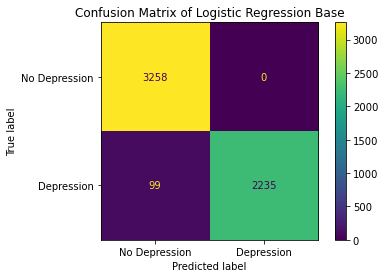

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-reg

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-reg

In [48]:
# Classification report
logreg_preds = logreg.predict(x_test_scaled)
logreg_report = classification_report(y_test, logreg_preds, target_names=['No Depression', 'Depression'])
print(logreg_report)

# Confusion matrix
fig_logreg = plot_confusion_matrix(logreg, x_test_scaled, y_test, display_labels=['No Depression', 'Depression'])
plt.title('Confusion Matrix of Logistic Regression Base')
plt.show()

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


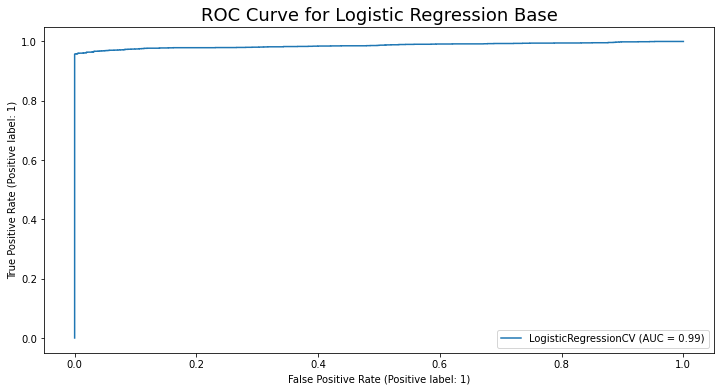

In [51]:
# ROC curve plot
f_logreg, ax3 = plt.subplots(figsize=(12, 6), ncols=1)
roc_logreg = plot_roc_curve(logreg, x_test_scaled, y_test, ax=ax3)
ax3.set_title('ROC Curve for Logistic Regression Base', fontdict={'fontsize':18})
ax3.legend()
plt.show()

In [53]:
# Start Grid Search for Logistic Regression Model

Cs_list = list(logreg.Cs_)
Cs_list

[0.0001,
 0.000774263682681127,
 0.005994842503189409,
 0.046415888336127774,
 0.3593813663804626,
 2.782559402207126,
 21.54434690031882,
 166.81005372000558,
 1291.5496650148827,
 10000.0]

In [56]:
params_logreg = {'C': Cs_list, 'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag']}

# Sklearn LogisticRegression is similar to LogisticRegressionCV though without the ability to specific the cv param
logreg_clf = LogisticRegression(random_state=42)

# Grid Searched Logistic Regression classifier. n_jobs specifies the number of CPU cores to use (-1=use all)
logreg_grid = GridSearchCV(logreg_clf, param_grid=params_logreg, scoring=f2_scorer, n_jobs=-1, cv=3)

# Train the Grid Searched Logistic Regression model
logreg_grid.fit(x_train_scaled, y_train)

GridSearchCV(cv=3, estimator=LogisticRegression(random_state=42), n_jobs=-1,
             param_grid={'C': [0.0001, 0.000774263682681127,
                               0.005994842503189409, 0.046415888336127774,
                               0.3593813663804626, 2.782559402207126,
                               21.54434690031882, 166.81005372000558,
                               1291.5496650148827, 10000.0],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag']},
             scoring=make_scorer(fbeta_score, beta=2))

In [57]:
logreg_grid.best_params_

{'C': 21.54434690031882, 'solver': 'newton-cg'}

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model

In [58]:
# Get the optimal tuned model for Logistic Regression
optimal_logreg = logreg_grid.best_estimator_

- Evaluate the tuned Logistic Regression Model

               precision    recall  f1-score   support

No Depression       0.97      1.00      0.99      3258
   Depression       1.00      0.96      0.98      2334

     accuracy                           0.98      5592
    macro avg       0.99      0.98      0.98      5592
 weighted avg       0.98      0.98      0.98      5592



/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


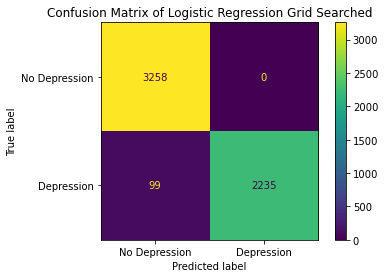

In [59]:
# Classification report
opt_logreg_preds = optimal_logreg.predict(x_test_scaled)
opt_logreg_report = classification_report(y_test, opt_logreg_preds, target_names=['No Depression', 'Depression'])
print(opt_logreg_report)

# Confusion matrix
fig_opt_logreg = plot_confusion_matrix(optimal_logreg, x_test_scaled, y_test, display_labels=['No Depression', 'Depression'])
plt.title('Confusion Matrix of Logistic Regression Grid Searched')
plt.show()

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


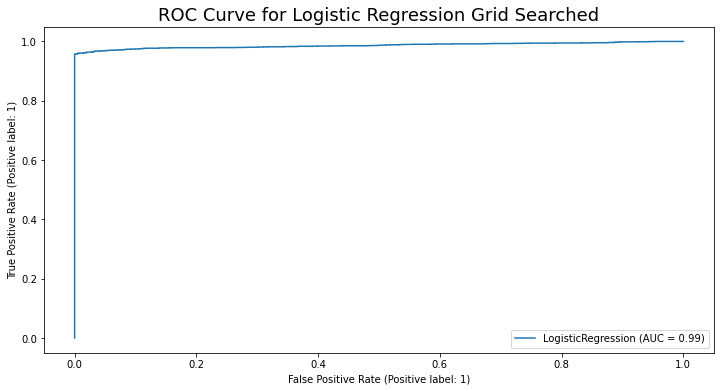

In [61]:
# ROC curve plot
f_opt_logreg, ax4 = plt.subplots(figsize=(12, 6), ncols=1)
roc_opt_logreg = plot_roc_curve(optimal_logreg, x_test_scaled, y_test, ax=ax4)
ax4.set_title('ROC Curve for Logistic Regression Grid Searched', fontdict={'fontsize':18})
ax4.legend()
plt.show()

## Multi-layer Perceptron Classifier Base and Tuned Networks
- Base Parameter/Hyperparameter configs:
    - hidden_layer_sizes: (1, 2) -> 1 hidden layer with 2 units
we start with a shallow network and steadily build more complex to allow for increased hypothesis learning space
    - activation: logistic -> the problem at hand is binary classification to build upon the Logistic Regression classifier
    - solver: lbfgs -> the baseline logreg model uses this solver and achieves good performance
    - validation_fraction: 0.2 -> allows the classifier to evaluate model performance on a hold-out set before test set evaluation

In [76]:
mlp = MLPClassifier(hidden_layer_sizes=(2, 2), activation='logistic', solver='lbfgs', validation_fraction=0.2)


# Train the shallow Multi-layer Perception baseline network
mlp.fit(x_train_scaled, y_train)

MLPClassifier(activation='logistic', hidden_layer_sizes=(2, 2), solver='lbfgs',
              validation_fraction=0.2)

               precision    recall  f1-score   support

No Depression       0.97      1.00      0.98      3258
   Depression       1.00      0.96      0.98      2334

     accuracy                           0.98      5592
    macro avg       0.98      0.98      0.98      5592
 weighted avg       0.98      0.98      0.98      5592



/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


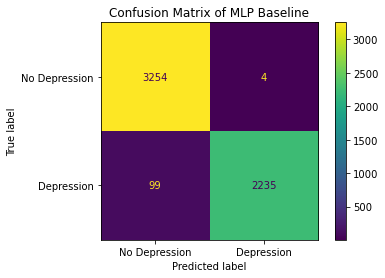

In [77]:
# Classification report
mlp_preds = mlp.predict(x_test_scaled)
mlp_report = classification_report(y_test, mlp_preds, target_names=['No Depression', 'Depression'])
print(mlp_report)

# Confusion matrix
fig_mlp = plot_confusion_matrix(mlp, x_test_scaled, y_test, display_labels=['No Depression', 'Depression'])
plt.title('Confusion Matrix of MLP Baseline')
plt.show()

- We adjust parameters as follows:
    - hidden_layer_sizes: (5, 5)
    - solver: 'adam'
    - learning_rate_init: 0.001
    - batch_size: 32
    - validation_fraction: 0.2

In [65]:
tuned_mlp = MLPClassifier(hidden_layer_sizes=(5, 5), solver='adam', activation='logistic', learning_rate_init=0.001,
                         batch_size=32, validation_fraction=0.2)

# Train the tuned MLP classifier
tuned_mlp.fit(x_train_scaled, y_train)

MLPClassifier(activation='logistic', batch_size=32, hidden_layer_sizes=(5, 5),
              validation_fraction=0.2)

               precision    recall  f1-score   support

No Depression       0.97      1.00      0.98      3258
   Depression       1.00      0.96      0.98      2334

     accuracy                           0.98      5592
    macro avg       0.98      0.98      0.98      5592
 weighted avg       0.98      0.98      0.98      5592



/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


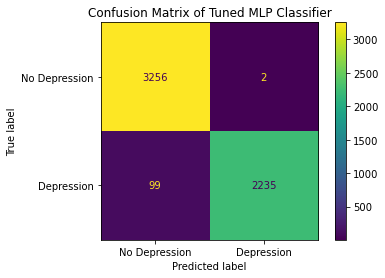

In [66]:
# Classification report
tuned_mlp_preds = tuned_mlp.predict(x_test_scaled)
tuned_mlp_report = classification_report(y_test, tuned_mlp_preds, target_names=['No Depression', 'Depression'])
print(tuned_mlp_report)

# Confusion matrix
fig_tuned_mlp = plot_confusion_matrix(tuned_mlp, x_test_scaled, y_test, display_labels=['No Depression', 'Depression'])
plt.title('Confusion Matrix of Tuned MLP Classifier')
plt.show()

- Second tuning of MLP
    - hidden_layer_sizes: (8,8)
    - batch_size: 16
    - learning_rate_init: 0.01
    - validation_fraction: 0.1

In [72]:
tuned2_mlp = MLPClassifier(hidden_layer_sizes=(8, 8), batch_size=16, solver='adam', learning_rate_init=0.01,
                          validation_fraction=0.1)

# train the second tuned MLP classifier
tuned2_mlp.fit(x_train_scaled, y_train)

MLPClassifier(batch_size=16, hidden_layer_sizes=(8, 8), learning_rate_init=0.01)

               precision    recall  f1-score   support

No Depression       0.97      1.00      0.99      3258
   Depression       1.00      0.96      0.98      2334

     accuracy                           0.98      5592
    macro avg       0.99      0.98      0.98      5592
 weighted avg       0.98      0.98      0.98      5592



/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


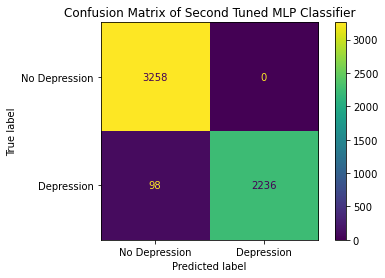

In [73]:
# Classification report
tuned2_mlp_preds = tuned2_mlp.predict(x_test_scaled)
tuned2_mlp_report = classification_report(y_test, tuned2_mlp_preds, target_names=['No Depression', 'Depression'])
print(tuned2_mlp_report)

# Confusion matrix
fig_tuned2_mlp = plot_confusion_matrix(tuned2_mlp, x_test_scaled, y_test, display_labels=['No Depression', 'Depression'])
plt.title('Confusion Matrix of Second Tuned MLP Classifier')
plt.show()

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


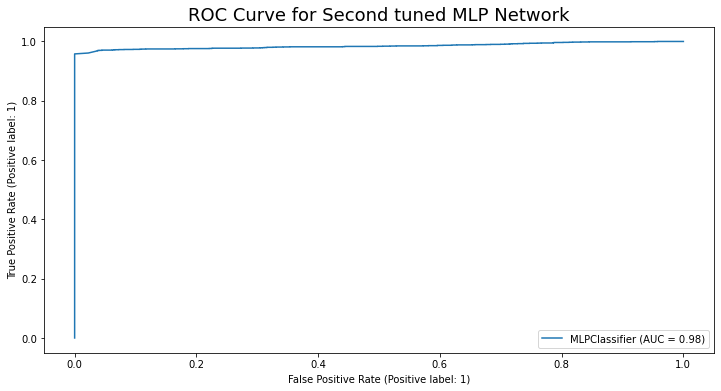

In [75]:
# ROC curve plot
f_tuned2mlp, ax5 = plt.subplots(figsize=(12, 6), ncols=1)
roc_tuned2 = plot_roc_curve(tuned2_mlp, x_test_scaled, y_test, ax=ax5)
ax5.set_title('ROC Curve for Second tuned MLP Network', fontdict={'fontsize':18})
ax5.legend()
plt.show()

# End of modeling